<div class="alert alert-block alert-success" style="font-size:30px">
🦴 Pytorch EfficientNetV2 vertebrae detection (acc: 0.95) 🦴
</div>

<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>

This notebook generates a dataset with C1-C7 vertebrae detections using bare-bones Pytorch and EfficientNet-V2 model.
Here we solve the most simple possible problem - we directly predict existence of vertebrae in the image instead of running a full-fledged pixel segmentation of scans.


![vertebrae_prediction.drawio.png](https://iili.io/4TBrN4.png)


Correct vertebrae labels are essential when training the fracture prediction model. Models trained in this notebook could also be used directly in the submission.


1. First we extract vertebrae targets from segmentation files. This is already done in ../input/rsna-2022-spine-fracture-detection-metadata dataset.
2. Next we build an EfficientNet-V2 based multi-label classification models.
3. Finally, we average N=5 models to produce vertebrae predictions.

## Results
Results were tested with groupped k-fold cross validation with grouping by StudyInstanceUID. It's very important to evaluate on StudyInstanceUID instances outside of the training set, because slices within the same StudyInstanceUID are highly correlated and results otherwise will be unrealistic.

Here we compare performance of this notebook with the simple detection using RandomForestClassifier features only that is done in ["Extracting Vertebrae C1, ..., C7"](https://www.kaggle.com/code/samuelcortinhas/extracting-vertebrae-c1-c7) notebook:

|                                                                                                              | CV accuracy |
|--------------------------------------------------------------------------------------------------------------|-------------|
| Effnetv2                                                                                                     | **0.95**        |
| ["Extracting Vertebrae C1, ..., C7"](https://www.kaggle.com/code/samuelcortinhas/extracting-vertebrae-c1-c7) | 0.88        |


## About EfficientNet-V2

EfficientNetV2 is a new family of convolutional networks that have faster training speed and better parameter efficiency than previous models. To develop these models, a combination of training-aware neural architecture search and scaling was used to jointly optimize
training speed and parameter efficiency. The models were searched from the search space enriched
with new ops such as Fused-MBConv. Experiments show that EfficientNetV2 models train much faster than state-of-the-art models while being up to 6.8x smaller.

With progressive learning, our EfficientNetV2 significantly outperforms previous models on ImageNet and CIFAR/Cars/Flowers datasets. By
pretraining on the same ImageNet21k, EfficientNetV2 achieves 87.3% top-1 accuracy on ImageNet ILSVRC2012, outperforming the recent ViT by 2.0% accuracy while training 5x-11x faster using the same computing resources

![Screenshot from 2022-08-26 21-20-36.png](https://miro.medium.com/max/922/1*rZtosLGF5qx1MmRILfKgdA.png)

<div class="alert alert-block alert-success" style="font-size:25px">
🦴 1. Imports, constants, dependencies 🦴
</div>

In [1]:
from typing import List

try:
    import pylibjpeg
except:
    # Offline dependencies for jpeg data extraction and torchvisioin 0.13 (required for EfficientNetV2)
    !mkdir -p /root/.cache/torch/hub/checkpoints/
    !cp ../input/rsna-2022-whl/efficientnet_v2_s-dd5fe13b.pth  /root/.cache/torch/hub/checkpoints/
    !pip install /kaggle/input/rsna-2022-whl/{pydicom-2.3.0-py3-none-any.whl,pylibjpeg-1.4.0-py3-none-any.whl,python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl}
    !pip install /kaggle/input/rsna-2022-whl/{torch-1.12.1-cp37-cp37m-manylinux1_x86_64.whl,torchvision-0.13.1-cp37-cp37m-manylinux1_x86_64.whl}

In [2]:
import gc
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom as dicom
import torch
import torchvision as tv
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, KFold
from torch.cuda.amp import GradScaler
from torch.cuda.amp import autocast
from torchvision.models.feature_extraction import create_feature_extractor
from tqdm.notebook import tqdm

import wandb

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)


# Effnet
WEIGHTS = tv.models.efficientnet.EfficientNet_V2_S_Weights.DEFAULT

TRAIN_IMAGES_PATH = '../../train_images'
TEST_IMAGES_PATH = '../../test_images'
METADATA_PATH = '../../'
EFFNET_CHECKPOINTS_PATH = '../../vertebrae-detection-checkpoints'

EFFNET_MAX_TRAIN_BATCHES = 10000
EFFNET_MAX_EVAL_BATCHES = 1000
ONE_CYCLE_MAX_LR = 0.0004
ONE_CYCLE_PCT_START = 0.3
SAVE_CHECKPOINT_EVERY_STEP = 500
N_MODELS_FOR_INFERENCE = 2


# Common
# os.environ["WANDB_MODE"] = "offline"
os.environ["WANDB_MODE"] = "online"

if os.environ["WANDB_MODE"] == "online":
    try:
        from kaggle_secrets import UserSecretsClient
        os.environ['WANDB_API_KEY'] = UserSecretsClient().get_secret("WANDB_API_KEY")
    except:
        #  We are running on a laptop
        print('running locally')
        TRAIN_IMAGES_PATH = '../../train_images'
        TEST_IMAGES_PATH = '../../rsna2022/test_images'
        EFFNET_CHECKPOINTS_PATH = '../../seg_checkpoints'
        METADATA_PATH = '../../'
        os.environ['WANDB_API_KEY'] = '95e4d37f7a7583a07e09e923de3bdad15dc00589'

DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    BATCH_SIZE = 32
else:
    BATCH_SIZE = 2
N_FOLDS = 5

running locally


<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 2. Vertebrae detection dataset
</div>

Text(0.5, 1.0, 'jpeg')

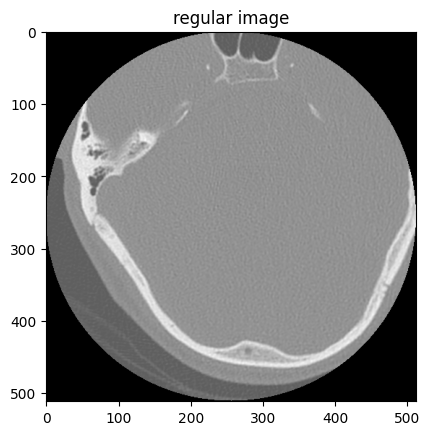

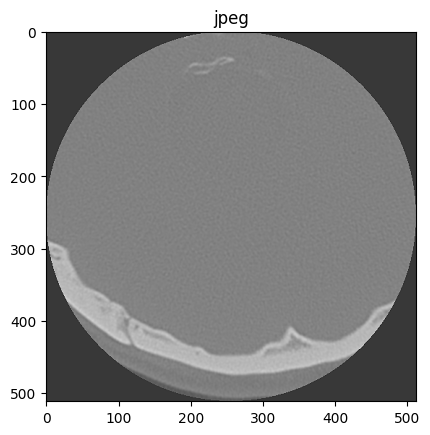

In [3]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data=(data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img


im, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10001/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('regular image')

im, meta = load_dicom(f'{TRAIN_IMAGES_PATH}/1.2.826.0.1.3680043.10014/1.dcm')
plt.figure()
plt.imshow(im)
plt.title('jpeg')

In [4]:
import pandas as pd
df_seg = pd.read_csv(f'{METADATA_PATH}/meta_segmentation.csv')

split = GroupKFold(N_FOLDS)
for k, (train_idx, test_idx) in enumerate(split.split(df_seg, groups=df_seg.StudyInstanceUID)):
    df_seg.loc[test_idx, 'split'] = k

split = KFold(N_FOLDS)
for k, (train_idx, test_idx) in enumerate(split.split(df_seg)):
    df_seg.loc[test_idx, 'random_split'] = k

slice_max_seg = df_seg.groupby('StudyInstanceUID')['Slice'].max().to_dict()
df_seg['SliceRatio'] = 0
df_seg['SliceRatio'] = df_seg['Slice'] / df_seg['StudyInstanceUID'].map(slice_max_seg)

df_seg.sample(10)

,StudyInstanceUID,Slice,ImageHeight,ImageWidth,SliceThickness,ImagePositionPatient_x,ImagePositionPatient_y,ImagePositionPatient_z,C1,C2,C3,C4,C5,C6,C7,split,random_split,SliceRatio
11912,1.2.826.0.1.3680043.24140,12,512,512,1.000,-59.863200,-52.363280,-475.800000,0,0,0,0,0,0,0,3.0,1.0,0.050209
11182,1.2.826.0.1.3680043.2243,147,512,512,1.000,-74.000000,43.000000,-120.299988,0,1,0,0,0,0,0,1.0,1.0,0.330337
17078,1.2.826.0.1.3680043.26990,106,512,512,0.625,-84.500000,-61.100000,-64.060000,0,0,1,1,0,0,0,0.0,2.0,0.438017
26361,1.2.826.0.1.3680043.5782,113,512,512,0.600,-102.331055,-247.831055,-979.800000,0,0,0,0,0,0,0,1.0,4.0,0.198594
2136,1.2.826.0.1.3680043.1363,11,512,512,1.000,-149.208008,-350.208008,64.000000,0,0,0,0,0,0,0,3.0,0.0,0.055276
16787,1.2.826.0.1.3680043.26979,113,512,512,0.625,-75.500000,-39.300000,-71.250000,0,1,1,0,0,0,0,2.0,2.0,0.379195
29570,1.2.826.0.1.3680043.8884,212,512,512,1.000,-87.344730,-245.344700,-190.100000,0,0,0,0,0,1,1,4.0,4.0,0.699670
8886,1.2.826.0.1.3680043.19388,372,512,512,0.600,-89.311523,-272.811523,69.100000,0,0,0,0,0,1,1,4.0,1.0,0.756098
15693,1.2.826.0.1.3680043.26498,261,512,512,0.625,-120.900000,-67.000000,-144.500000,0,0,0,0,0,0,0,3.0,2.0,0.719008
15978,1.2.826.0.1.3680043.26740,183,512,512,0.625,-68.400000,-34.700000,-115.500000,0,0,0,0,0,1,1,0.0,2.0,0.639860


In [5]:
class VertebraeSegmentDataSet(torch.utils.data.Dataset):
    def __init__(self, df, path, transforms=None):
        super().__init__()
        self.df = df
        self.path = path
        self.transforms = transforms

    def __getitem__(self, i):
        path = os.path.join(self.path, self.df.iloc[i].StudyInstanceUID, f'{self.df.iloc[i].Slice}.dcm')
        try:
            img = load_dicom(path)[0]
            img = np.transpose(img, (2, 0, 1))  # Pytorch uses (batch, channel, height, width) order. Converting (height, width, channel) -> (channel, height, width)
            if self.transforms is not None:
                img = self.transforms(torch.as_tensor(img))
        except Exception as ex:
            print(ex)
            return None

        if 'C1' in self.df.columns:
            vert_targets = torch.as_tensor(self.df.iloc[i][['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']].astype('float32').values)
            return img, vert_targets
        return img

    def __len__(self):
        return len(self.df)


ds_seg = VertebraeSegmentDataSet(df_seg, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
X, y = ds_seg[300]
X.shape, y.shape

(torch.Size([3, 384, 384]), torch.Size([7]))

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 3. Vertebrae detection model
</div>

Note how we extract 'flatten' layer using introspection capabilities of Pytorch (create_feature_extractor)

In [6]:
class SegEffnetModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        effnet = tv.models.efficientnet_v2_s(weights=WEIGHTS)
        self.model = create_feature_extractor(effnet, ['flatten'])
        self.nn_vertebrae = torch.nn.Sequential(
            torch.nn.Linear(1280, 7),
        )

    def forward(self, x):
        # returns logits
        x = self.model(x)['flatten']
        return self.nn_vertebrae(x)

    def predict(self, x):
        pred = self.forward(x)
        return torch.sigmoid(pred)

# quick test
model = SegEffnetModel()
model.predict(torch.randn(1, 3, 512, 512))
del model

<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 4. Model training/evaluation
</div>

* We save/load pytorch models manually in `save_model`, `load_model`
* We estimate accuracy metric in `evaluate_segeffnet`
* 5 models are trained in total with GroupKFold.
* OneCycleLR scheduler is used as it is one of the most compute efficient schedulers for 1 epoch training with small amount of data.
* Mixed precision is used to speed up training on Ampere GPUs with fp16.
* wandb inline and remote metrics are generated

In [7]:
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [8]:
def filter_nones(b):
    return torch.utils.data.default_collate([v for v in b if v is not None])

In [9]:
def save_model(name, model, optim, scheduler):
    torch.save({
        'model': model.state_dict(),
        'optim': optim.state_dict(),
        'scheduler': scheduler
    }, f'{name}.tph')

def load_model(model, name, path='.'):
    data = torch.load(os.path.join(path, f'{name}.tph'), map_location=DEVICE)
    model.load_state_dict(data['model'])
    optim = torch.optim.Adam(model.parameters())
    optim.load_state_dict(data['optim'])
    return model, optim, data['scheduler']

# quick test
model = torch.nn.Linear(2, 1)
optim = torch.optim.Adam(model.parameters())
save_model('testmodel', model, optim, None)

model1, optim1, scheduler1 = load_model(torch.nn.Linear(2, 1), 'testmodel')
assert torch.all(next(iter(model1.parameters())) == next(iter(model.parameters()))).item(), "Loading/saving is inconsistent!"

In [10]:
def evaluate_segeffnet(model: SegEffnetModel, ds, max_batches=1e9, shuffle=False):
    torch.manual_seed(42)
    model = model.to(DEVICE)
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=shuffle, num_workers=os.cpu_count(), collate_fn=filter_nones)
    with torch.no_grad():
        model.eval()
        pred = []
        y = []
        progress = tqdm(dl_test, desc='Eval', miniters=100)
        for i, (X, y_vert) in enumerate(progress):
            with autocast():
                y_vert_pred = model.predict(X.to(DEVICE))
            pred.append(y_vert_pred.cpu().numpy())
            y.append(y_vert.numpy())
            acc = np.mean(np.mean((pred[-1] > 0.5) == y[-1], axis=0))
            progress.set_description(f'Eval acc: {acc:.02f}')
            if i >= max_batches:
                break
        pred = np.concatenate(pred)
        y = np.concatenate(y)
        acc = np.mean(np.mean((pred > 0.5) == y, axis=0))
        return acc, pred

In [20]:
%%wandb


def train_segeffnet(ds_train, ds_eval, logger, name):
    torch.manual_seed(42)
    dl_train = torch.utils.data.DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count(), collate_fn=filter_nones)


    model = SegEffnetModel().to(DEVICE)
    optim = torch.optim.Adam(model.parameters())
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optim, max_lr=ONE_CYCLE_MAX_LR, epochs=1, steps_per_epoch=min(EFFNET_MAX_TRAIN_BATCHES, len(dl_train)), pct_start=ONE_CYCLE_PCT_START)
    model.train()
    scaler = GradScaler()

    progress = tqdm(dl_train, desc='Train', miniters=10)
    for batch_idx, (X,  y_vert) in enumerate(progress):

        if batch_idx % SAVE_CHECKPOINT_EVERY_STEP == 0 and EFFNET_MAX_EVAL_BATCHES > 0:
            eval_loss = evaluate_segeffnet(model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[0]
            model.train()
            if logger is not None:
                logger.log({'eval_acc': eval_loss})
            if batch_idx > 0:  # don't save untrained model
                save_model(name, model, optim, scheduler)

        if batch_idx >= EFFNET_MAX_TRAIN_BATCHES:
            break

        optim.zero_grad()
        with autocast():
            y_vert_pred = model.forward(X.to(DEVICE))
            loss = torch.nn.functional.binary_cross_entropy_with_logits(y_vert_pred, y_vert.to(DEVICE))

            if np.isinf(loss.item()) or np.isnan(loss.item()):
                print(f'Bad loss, skipping the batch {batch_idx}')
                del y_vert_pred, loss
                gc_collect()
                continue

        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        scheduler.step()

        progress.set_description(f'Train loss: {loss.item():.02f}')
        if logger is not None:
            logger.log({'loss': loss.item(), 'lr': scheduler.get_last_lr()[0]})


    eval_loss = evaluate_segeffnet(model, ds_eval, max_batches=EFFNET_MAX_EVAL_BATCHES, shuffle=True)[0]
    if logger is not None:
        logger.log({'eval_acc': eval_loss})

    save_model(name, model, optim, scheduler)
    return model


seg_models = []
for fold in range(N_FOLDS):
    fname = os.path.join(f'{EFFNET_CHECKPOINTS_PATH}/segeffnetv2-f{fold}.tph')
    if os.path.exists(fname):
        print(f'Found cached model {fname}')
        seg_models.append(load_model(SegEffnetModel(), f'segeffnetv2-f{fold}', EFFNET_CHECKPOINTS_PATH)[0].to(DEVICE))
    else:
        with wandb.init(project='RSNA-2022', name=f'SegEffNet-v2-fold{fold}') as run:
            gc_collect()
            ds_train = VertebraeSegmentDataSet(df_seg.query('split != @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            ds_eval = VertebraeSegmentDataSet(df_seg.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
            train_segeffnet(ds_train, ds_eval, run, f'segeffnetv2-f{fold}')

Train:   0%|          | 0/748 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

eval_acc,▁██
loss,█▇▆▄▄▃▄▄▂▂▂▃▂▂▂▂▂▂▂▁▂▁▂▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁
lr,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
eval_acc,0.96875
loss,0.0606
lr,0.0


Train:   0%|          | 0/743 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

eval_acc,▁██
loss,█▇▇▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁
lr,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▆▅▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁
eval_acc,0.95355
loss,0.03487
lr,0.0


Train:   0%|          | 0/748 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

eval_acc,▁██
loss,█▇▇▅▄▃▃▃▃▃▃▃▂▂▂▃▂▂▂▂▁▂▁▂▁▂▁▂▁▁▂▁▁▁▁▂▁▁▁▂
lr,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
eval_acc,0.94237
loss,0.03541
lr,0.0


Train:   0%|          | 0/748 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

/home/szs7220/miniconda3/envs/tf/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

eval_acc,▁██
loss,█▇▆▄▄▃▂▃▃▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁
lr,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
eval_acc,0.91805
loss,0.03113
lr,0.0


Train:   0%|          | 0/744 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

eval_acc,▁██
loss,█▇▆▅▄▃▂▃▃▃▃▃▂▃▂▃▂▃▂▂▂▂▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁
lr,▁▁▂▃▃▄▅▆▆▇███████▇▇▇▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁
eval_acc,0.97337
loss,0.05349
lr,0.0


In [27]:
for fold in range(N_FOLDS):
    fname = os.path.join(f'./segeffnetv2-f{fold}.tph')
    if os.path.exists(fname):
        print(f'Found cached model {fname}')
        seg_models.append(load_model(SegEffnetModel(), f'segeffnetv2-f{fold}', './')[0].to(DEVICE))
print(seg_models)

Found cached model ./segeffnetv2-f0.tph
Found cached model ./segeffnetv2-f1.tph
Found cached model ./segeffnetv2-f2.tph
Found cached model ./segeffnetv2-f3.tph
Found cached model ./segeffnetv2-f4.tph
[SegEffnetModel(
  (model): EfficientNet(
    (features): Module(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Module(
        (0): Module(
          (block): Module(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): Module(
          (block):

In [28]:
seg_models

[SegEffnetModel(
   (model): EfficientNet(
     (features): Module(
       (0): Conv2dNormActivation(
         (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
         (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
         (2): SiLU(inplace=True)
       )
       (1): Module(
         (0): Module(
           (block): Module(
             (0): Conv2dNormActivation(
               (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
               (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
               (2): SiLU(inplace=True)
             )
           )
           (stochastic_depth): StochasticDepth(p=0.0, mode=row)
         )
         (1): Module(
           (block): Module(
             (0): Conv2dNormActivation(
               (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
               (1): BatchNorm2d(2

In [29]:
with tqdm(seg_models, desc='Fold') as progress:
    for fold, model in enumerate(progress):
        ds = VertebraeSegmentDataSet(df_seg.query('split == @fold'), TRAIN_IMAGES_PATH, WEIGHTS.transforms())
        acc, pred = evaluate_segeffnet(model, ds, max_batches=1e9, shuffle=False)
        df_seg.loc[df_seg[df_seg.split == fold].index, ['C1_pred', 'C2_pred', 'C3_pred', 'C4_pred', 'C5_pred', 'C6_pred', 'C7_pred']] = pred
        progress.set_description(f'Acc: {acc}')

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/185 [00:00<?, ?it/s]

Eval:   0%|          | 0/190 [00:00<?, ?it/s]

In [30]:
with tqdm(seg_models, desc='Fold') as progress:
    for fold, model in enumerate(progress):
        print(fold)

Fold:   0%|          | 0/5 [00:00<?, ?it/s]

0
1
2
3
4


In [32]:
acc = (df_seg[[f'C{i}_pred' for i in range(1, 8)]] > 0.5).values == (df_seg[[f'C{i}' for i in range(1, 8)]] > 0.5).values
print('Effnetv2 accuracy per vertebrae', np.mean(acc, axis=0))
print('Effnetv2 average accuracy', np.mean(np.mean(acc, axis=0)))

Effnetv2 accuracy per vertebrae [0.96208769 0.94090239 0.95598686 0.96057924 0.94817645 0.945059
 0.9465004 ]
Effnetv2 average accuracy 0.9513274336283187


<div class="alert alert-block alert-success" style="font-size:25px">
    🦴 6. Inference for 100% of training slices
</div>

Here we'll average outputs of 5 models and store predictions for all train samples

In [33]:
def predict_vertebrae(df, seg_models: List[SegEffnetModel]):
    df = df.copy()
    ds = VertebraeSegmentDataSet(df, TRAIN_IMAGES_PATH, WEIGHTS.transforms())
    dl_test = torch.utils.data.DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count(), collate_fn=filter_nones)
    predictions = []
    with torch.no_grad():
        with tqdm(dl_test, desc='Eval', miniters=10) as progress:
            for i, X in enumerate(progress):
                with autocast():
                    pred = torch.zeros(len(X), 7).to(DEVICE)
                    for model in seg_models:
                        pred += model.predict(X.to(DEVICE)) / len(seg_models)
                    predictions.append(pred)
    predictions = torch.concat(predictions).cpu().numpy()
    return predictions

In [34]:
df_train = pd.read_csv(os.path.join(METADATA_PATH, 'meta_train_clean.csv'))

Eval:   0%|          | 0/10 [00:00<?, ?it/s]

Eval:   0%|          | 0/23 [00:00<?, ?it/s]

Eval:   0%|          | 0/13 [00:00<?, ?it/s]

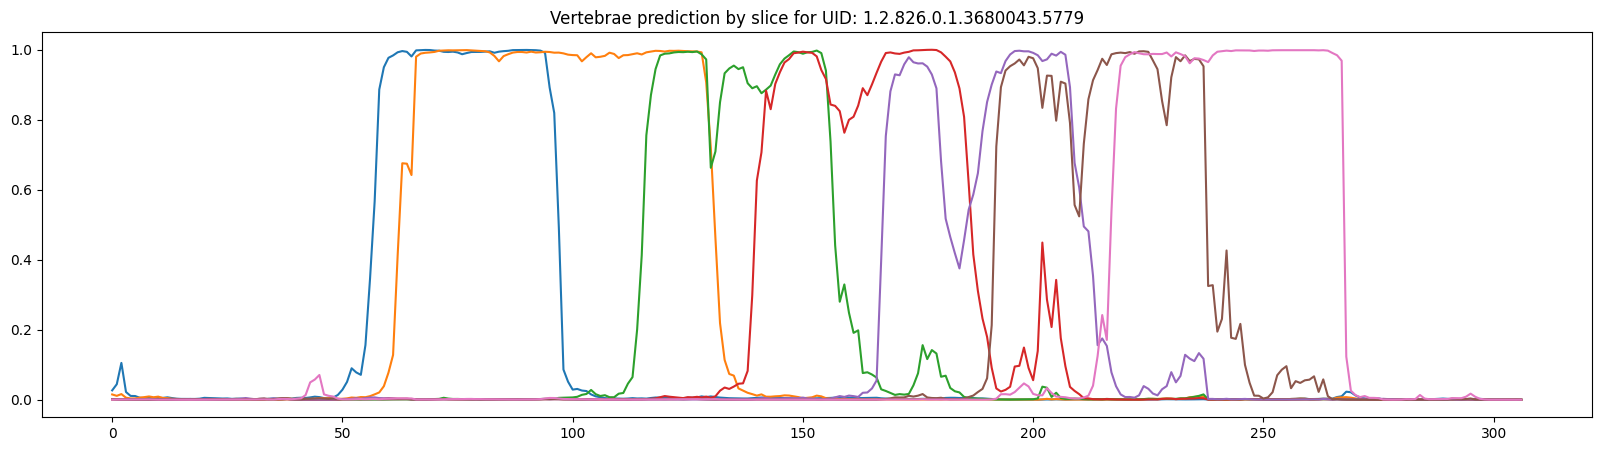

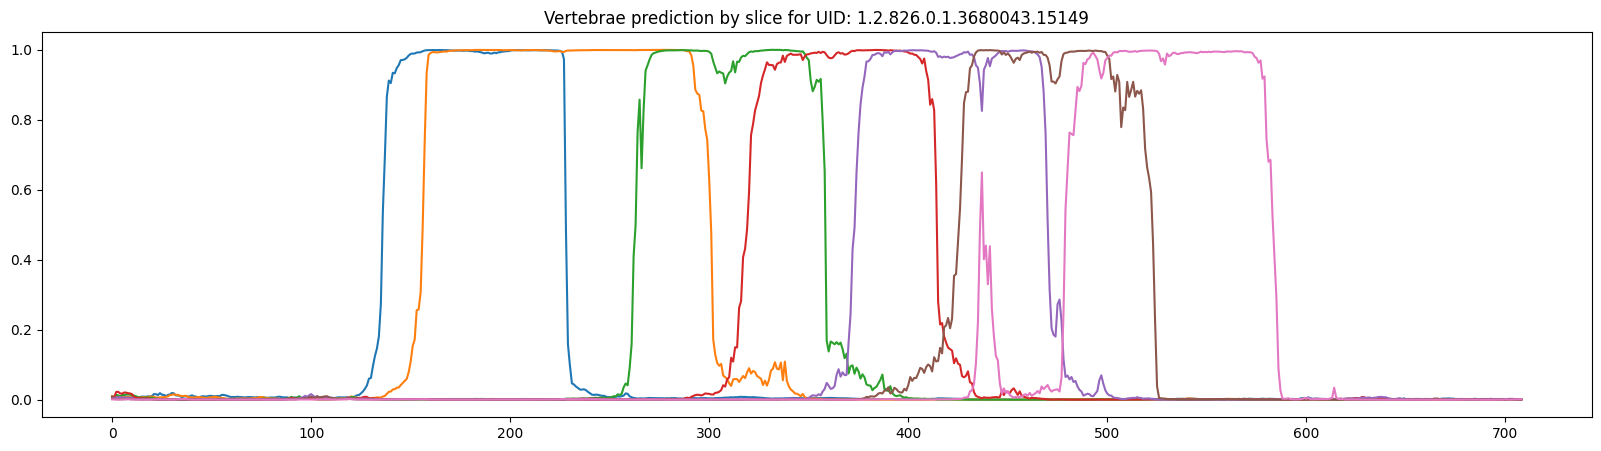

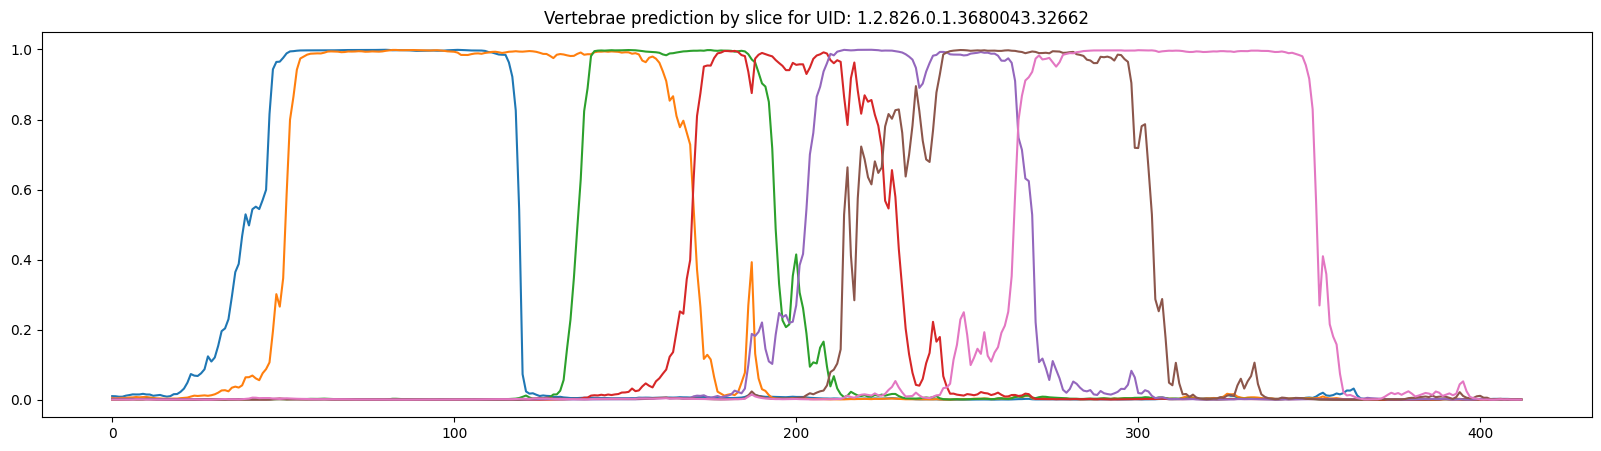

In [35]:
for uid in np.random.choice(df_train.StudyInstanceUID, 3):
    pred = predict_vertebrae(df_train.query('StudyInstanceUID == @uid'), seg_models[:2])
    plt.figure(figsize=(20, 5))
    plt.plot(pred)
    plt.title(f'Vertebrae prediction by slice for UID: {uid}')

In [ ]:
pred = predict_vertebrae(df_train, seg_models[:N_MODELS_FOR_INFERENCE])

Eval:   0%|          | 0/22238 [00:00<?, ?it/s]

In [ ]:
df_train[[f'C{i}' for i in range(1, 8)]] = pred
df_train.to_csv('train_segmented.csv', index=False)

# you can find checkpoints along with the output dataset in https://www.kaggle.com/datasets/vslaykovsky/vertebrae-detection-checkpoints

In [ ]:
df_train

<div class="alert alert-block alert-danger" style="text-align:center; font-size:20px;">
    ❤️ Dont forget to ▲upvote▲ if you find this notebook usefull!  ❤️
</div>